In [1]:
from datasets import load_dataset
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen import attention as attn
from typing import Any, Callable
import optax
import time
import wandb
import matplotlib.pyplot as plt

import sys
from pathlib import Path

root = Path.cwd().parent
sys.path.append(str(root))

from models.decoder_only_transformer_RoPE import DecoderOnlyTransformer

/home/exyzt/projects/DSA4212-Transformer-Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check GPU Availablity

In [2]:
print("JAX is using:", jax.default_backend())
print("All available devices:", jax.devices())

JAX is using: gpu
All available devices: [CudaDevice(id=0)]


### Data Preparation

#### Loading the Dataset

In [3]:
dataset = load_dataset("afmck/text8")

print(dataset)
print(dataset["train"][0]["text"][:500])

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


In [4]:
train_text = dataset["train"][0]["text"]
val_text = dataset["validation"][0]["text"]

print(f"Length of train text: {len(train_text):,} characters")
print(f"Length of validation text: {len(val_text):,} characters")

Length of train text: 90,000,000 characters
Length of validation text: 5,000,000 characters


### Tokenizer

#### Building the Tokenizer

In [5]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

def decode(ids):
    """Decode array of integers to string"""
    return ''.join(int_to_char[i] for i in ids)
# Test encoding and decoding
test_str = "hello world"
encoded = encode(test_str)
decoded = decode(encoded)
assert test_str == decoded, "Encoding/decoding failed"
print(f"Test string 1: {test_str}")

Test string 1: hello world


#### Tokenize the Dataset

In [6]:
train_text_int = encode(train_text)
test_text_int = encode(val_text)

### Model Building

In [7]:
def create_train_state(
    rng,
    vocab_size,
    d_model,
    n_layers,
    n_heads,
    mlp_ratio,
    emb_dropout,
    attn_dropout,
    mlp_dropout,
    param_dtype,
    compute_dtype,
    kernel_init,
    proj_init,
):

    # Instantiate the model with all given hyperparameters
    model = DecoderOnlyTransformer(
        vocab_size=vocab_size,
        d_model=d_model,
        n_layers=n_layers,
        n_heads=n_heads,
        mlp_ratio=mlp_ratio,
        emb_dropout=emb_dropout,
        attn_dropout=attn_dropout,
        mlp_dropout=mlp_dropout,
        param_dtype=param_dtype,
        compute_dtype=compute_dtype,
        kernel_init=kernel_init,
        proj_init=proj_init,
    )

    # Create dummy input for initialization (single batch of zeros)
    dummy = jnp.zeros((1, 16), dtype=jnp.int32)

    # Initialize model parameters (include dropout rng)
    variables = model.init({"params": rng, "dropout": rng}, dummy, deterministic=False)

    # Extract parameters only (not batch stats etc.)
    params = variables["params"]

    return model, params

### Loss Function

In [8]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)
    
    # compute accuracy over only the last position
    is_match = preds == targets
    
    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    
    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

In [ ]:
rng = jax.random.PRNGKey(0)

configs = {
    "vocab_size": len(char_set),
    "d_model": 256,
    "n_layers": 6,
    "n_heads": 8,
    "mlp_ratio": 4,
    "emb_dropout": 0.1,
    "attn_dropout": 0.1,
    "mlp_dropout": 0.1,
    "param_dtype": jnp.float32,
    "compute_dtype": jnp.float32,
    "kernel_init": nn.initializers.xavier_normal(),
    "proj_init": nn.initializers.normal(stddev=1e-4),
    "learning_rate": optax.warmup_exponential_decay_schedule(
        init_value=0.0,
        peak_value=6e-4,
        warmup_steps=2000,
        decay_steps=100000,
    ),
    "optimizer": optax.adamw,
}

model_params = [
    "vocab_size",
    "d_model",
    "n_layers",
    "n_heads",
    "mlp_ratio",
    "emb_dropout",
    "attn_dropout",
    "mlp_dropout",
    "param_dtype",
    "compute_dtype",
    "kernel_init",
    "proj_init",
]

model_configs = {param: configs[param] for param in model_params}

model, params = create_train_state(rng, **model_configs)

# Run logging with Wandb
wandb.login()

run = wandb.init(
    config=configs,
    name="Decoder-Only-Transformers w/ RoPE - Test 4",
    notes="Warmup Exponential Decay Schedule, Batch = 128, Context Length = 64"
)

wandb: Currently logged in as: exyzt3d (exyzt3d-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Optimization Step

In [10]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

### Batch Creation

In [11]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)    

### Optimizer Creation

In [12]:
# define optax optimizer
learning_rate = configs["learning_rate"]
# Create AdamW optimizer (Optax)
tx = configs["optimizer"](learning_rate=learning_rate)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: AdamW lr={learning_rate}")

Initialized optimizer: AdamW lr=<function join_schedules.<locals>.schedule at 0x7eb20a12dd00>


In [ ]:
niter = 100_000
B, T = 64, 256
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
time_start = time.time()
for it in range(1, niter + 1):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)
    run.log({
        "loss/train": loss, 
        "train_accuracy": acc, 
        "train_last_character_accuracy": acc_last,
    })

    if it % (niter // 50) == 0 or it == 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history.append(test_loss)
        time_test_history.append(time_since_start)
        run.log({
            "loss/test": test_loss, 
            "test_accuracy": test_acc, 
            "test_last_character_accuracy": test_acc_last,
        })
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()

iteration 1  time: 15.3 seconds
	 	 loss(train :: test): 3.2958 :: 3.2958
	 	 accuracy (train :: test): 3.7% :: 4.1%
	 	 accuracy (last character) (train :: test): 1.6% :: 4.4%

iteration 2_000  time: 217.4 seconds
	 	 loss(train :: test): 1.3480 :: 1.3719
	 	 accuracy (train :: test): 57.9% :: 57.1%
	 	 accuracy (last character) (train :: test): 64.1% :: 60.5%

iteration 4_000  time: 413.7 seconds
	 	 loss(train :: test): 1.2060 :: 1.2735
	 	 accuracy (train :: test): 61.9% :: 60.2%
	 	 accuracy (last character) (train :: test): 60.5% :: 62.2%

iteration 6_000  time: 747.1 seconds
	 	 loss(train :: test): 1.2082 :: 1.2425
	 	 accuracy (train :: test): 62.1% :: 60.9%
	 	 accuracy (last character) (train :: test): 63.7% :: 62.9%

iteration 8_000  time: 1156.1 seconds
	 	 loss(train :: test): 1.1908 :: 1.2422
	 	 accuracy (train :: test): 62.4% :: 60.9%
	 	 accuracy (last character) (train :: test): 64.5% :: 63.5%

iteration 10_000  time: 1558.6 seconds
	 	 loss(train :: test): 1.1570 ::

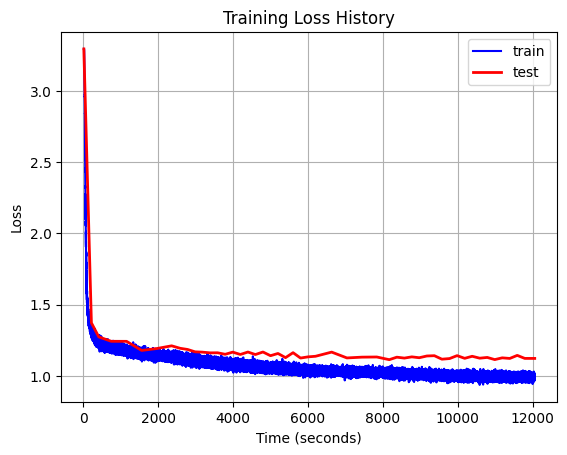

In [14]:
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

### Testing

In [15]:
def sample_categorical(rng, logits, temperature=1.0):
    """Sample from categorical distribution given by logits with temperature."""
    # logits: (B, V)
    if temperature != 1.0:
        logits = logits / temperature
    return jax.random.categorical(rng, logits, axis=-1)

#@functools.partial(jax.jit, static_argnames=("model", "block_size", "temperature", "sample"))
def generate_tokens(model, params, rng, context, length, block_size=64, temperature=1.0, sample=True):
    """Generate `length` new tokens autoregressively starting from `context`.

    Args:
      model: Flax/linen model object with apply signature model.apply({'params': params}, tokens)
      params: model parameters pytree.
      rng: jax PRNGKey (e.g., jax.random.PRNGKey(0)).
      context: int32 array shape (B, S) where S <= block_size. If S < block_size, left-pad with zeros or use full context.
      length: number of tokens to generate (int).
      block_size: model context window (static).
      temperature: sampling temperature (static).
      sample: if True use sampling; if False use argmax (greedy).

    Returns:
      generated: int32 array shape (B, length) of generated token ids.
    """
    B = context.shape[0]
    S = context.shape[1]
    assert S <= block_size, "context length must be <= block_size"

    # initialize running context: if S < block_size, left-pad with zeros (or use a preferred pad token)
    if S < block_size:
        pad_len = block_size - S
        context = jnp.concatenate([jnp.zeros((B, pad_len), dtype=jnp.int32), context], axis=1)

    def _step(carry, _):
        rng, ctx = carry  # rng: PRNGKey, ctx: (B, block_size)
        # forward pass: get logits for all positions, take last position
        logits = model.apply({"params": params}, ctx)  # (B, block_size, V)
        last_logits = logits[:, -1, :]  # (B, V)
        rng, subkey = jax.random.split(rng)
        if sample:
            next_token = jax.random.categorical(subkey, last_logits / (temperature if temperature>0 else 1.0), axis=-1)
        else:
            next_token = jnp.argmax(last_logits, axis=-1)
        next_token = next_token.astype(jnp.int32)
        # append to context: drop first token, append new token at end
        next_token_col = next_token.reshape(B, 1)
        new_ctx = jnp.concatenate([ctx[:, 1:], next_token_col], axis=1)
        return (rng, new_ctx), next_token_col

    # run scan for `length` steps
    (rng_final, ctx_final), tokens = jax.lax.scan(_step, (rng, context), None, length=length)
    # tokens: shape (length, B, 1) -> reshape to (B, length)
    tokens = tokens.squeeze(-1).transpose(1, 0)
    return tokens

In [16]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

gen_len = 1000
out_ids = generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64, 
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
#print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

generated ids shape: (1, 1000)
generated text:
hello my friend and impressionist pianist olivier maria sharpe stockzire s born appearance in one nine two two and one nine three two as a result of the united states and other regional groups at the battle of the iranian provinces of kuwait province central and south america since one nine seven zero and one nine eight zero and international english language scene in english politics and politics in welsh he also appealed to the privilege of the golden dawn parenting in management in both the beast and self portrait the first book of the years grand rapids the book of priests in the first half of the twelve articles of confederation from the united kingdom to latin religion its failure to conquer a central part of the seventh century and the rest of the language for germans is that no one particularly well distinguished parties from the party on the more detailed discussion of large well beyond the court in a similar court act on the firs

In [17]:
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):,}")

Number of parameters: 7,898,624


In [18]:
import pickle

with open('decoder_transformer_RoPE_model_params-T3.pkl', 'wb') as f:
    pickle.dump(params, f)